## Census Income Project

### Problem Statement:

This data was extracted from the 1994 Census bureau database by Ronny Kohavi and Barry Becker (Data Mining and Visualization, Silicon Graphics). A set of reasonably clean records was extracted using the following conditions: ((AAGE>16) && (AGI>100) && (AFNLWGT>1) && (HRSWK>0)). The prediction task is to determine whether a person makes over $50K a year.

### Description of fnlwgt (final weight)

The weights on the Current Population Survey (CPS) files are controlled to independent estimates of the civilian non-institutional population of the US. These are prepared monthly for us by Population Division here at the Census Bureau. We use 3 sets of controls. These are:

A single cell estimate of the population 16+ for each state.

Controls for Hispanic Origin by age and sex.

Controls by Race, age and sex.

We use all three sets of controls in our weighting program and "rake" through them 6 times so that by the end we come back to all the controls we used. The term estimate refers to population totals derived from CPS by creating "weighted tallies" of any specified socio-economic characteristics of the population. People with similar demographic characteristics should have similar weights. There is one important caveat to remember about this statement. That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state.



In [8]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt,joblib
from scipy.stats import zscore
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,average_precision_score
from sklearn.metrics import adjusted_mutual_info_score,balanced_accuracy_score,roc_curve,auc
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

### Importing Data

In [9]:
import pandas as pd
df=pd.read_csv("https://raw.githubusercontent.com/dsrscientist/dataset1/master/census_income.csv",sep=",") 
df.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K


In [10]:
df.dtypes

Age                int64
Workclass         object
Fnlwgt             int64
Education         object
Education_num      int64
Marital_status    object
Occupation        object
Relationship      object
Race              object
Sex               object
Capital_gain       int64
Capital_loss       int64
Hours_per_week     int64
Native_country    object
Income            object
dtype: object

In [7]:
df.shape

(32560, 15)

<AxesSubplot:>

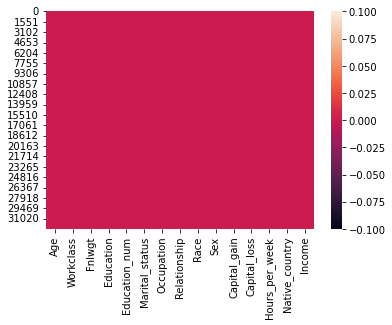

In [12]:
sns.heatmap(df.isnull())

In [13]:
nacolumns=df.columns[df.isnull().any()]

In [14]:
nacolumns=list(nacolumns)

In [15]:
df.drop(nacolumns,axis=1)

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
1,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
2,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
3,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
4,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32555,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32556,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32557,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32558,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [16]:
for col in ['Workclass', 'Occupation', 'Native_country']:
    df[col]=df[col].replace(' ?', df[col].mode()[0])

In [17]:
int_list=list(df.select_dtypes(['int64']).columns)

### Univariate Analysis

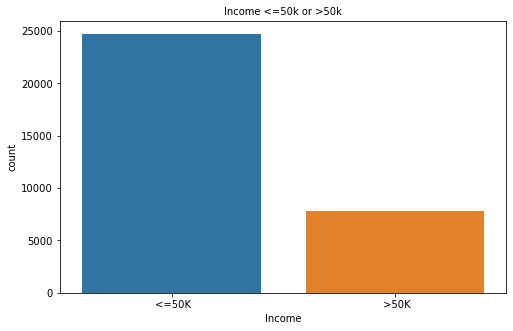

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,5)) 
sns.countplot(x="Income", data=df) 
plt.title("Income <=50k or >50k", fontsize = 10)
plt.show()

There are less number of people compared to the people who have earned more than 50k

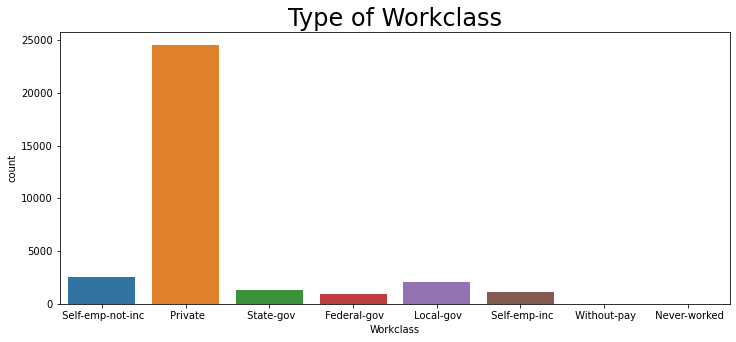

In [23]:
plt.figure(figsize = (12,5))
sns.countplot(x="Workclass", data=df)
plt.title("Type of Workclass", fontsize = 24)
plt.show()

As we can understand from above private emplyees participated more

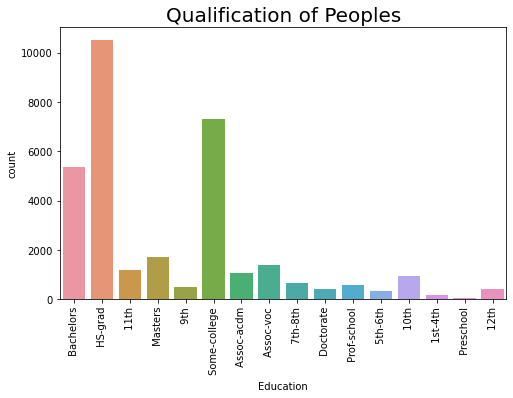

In [25]:
plt.figure(figsize = (8,5))
ax=sns.countplot(x="Education", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Qualification of Peoples", fontsize = 20)
plt.show()

The people who did HS-Grad is earning more than others

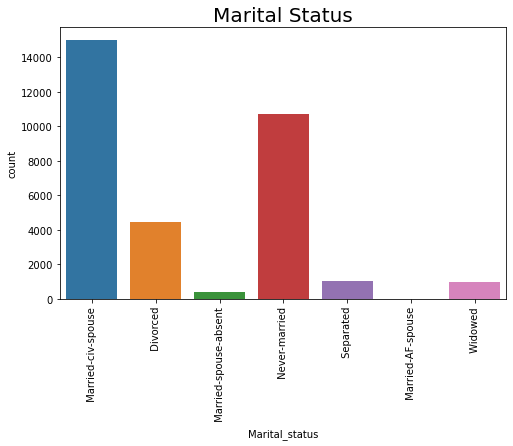

In [35]:
plt.figure(figsize = (8,5))
ax=sns.countplot(x="Marital_status", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Marital Status", fontsize = 20)
plt.show()

As we can see Married-cv-spouse is earning the most

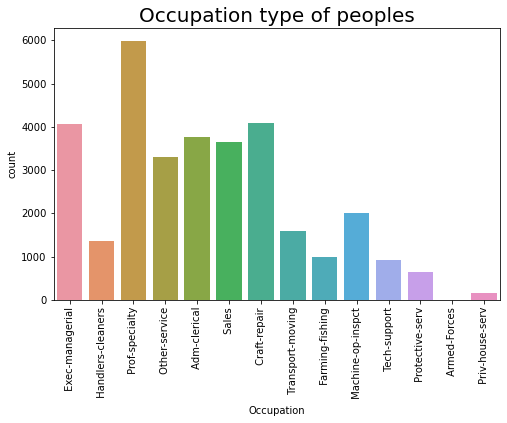

In [29]:
plt.figure(figsize = (8,5))
ax=sns.countplot(x="Occupation", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Occupation type of peoples", fontsize = 20)
plt.show()

Prof-speciality are the one who are having the more compared to others

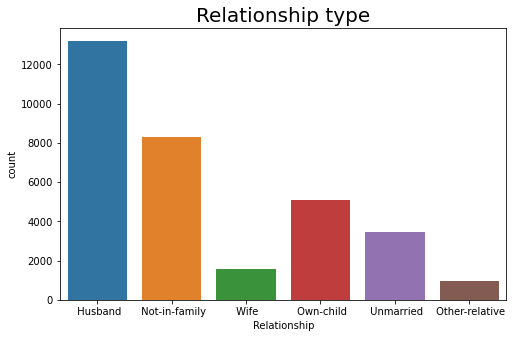

In [31]:
plt.figure(figsize = (8,5))
sns.countplot(x="Relationship", data=df)
plt.title("Relationship type", fontsize = 20)
plt.show()

Husband category are earning more than any other person of family

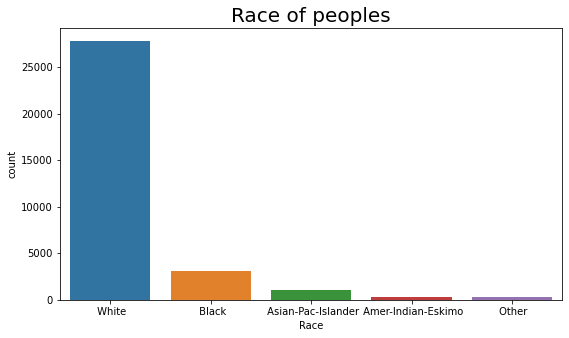

In [38]:
plt.figure(figsize = (9,5))
sns.countplot(x="Race", data=df)
plt.title("Race of peoples", fontsize = 20)
plt.show()

White peoples have more earning than other race of peoples

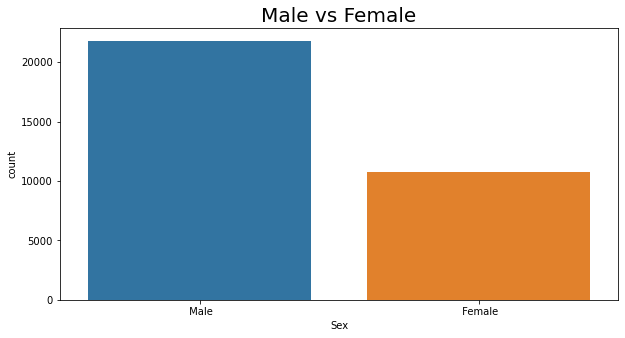

In [39]:
plt.figure(figsize = (10,5))
sns.countplot(x="Sex", data=df)
plt.title("Male vs Female", fontsize = 20)
plt.show()

Male is earning more than Female

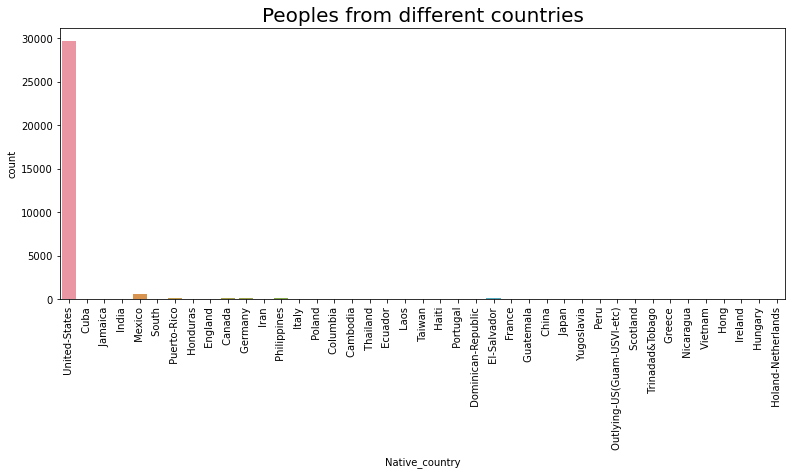

In [41]:
plt.figure(figsize = (13,5))
ax = sns.countplot(x="Native_country", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.title("Peoples from different countries", fontsize = 20)
plt.show()

People in United-States are earning more compared to people of other countries

### Bivariate Analysis

<AxesSubplot:xlabel='Income', ylabel='Age'>

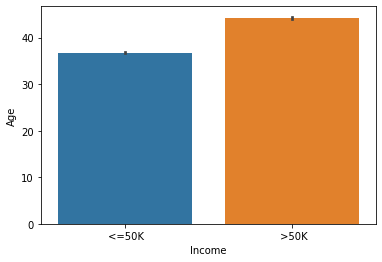

In [46]:
sns.barplot(x = 'Income', y = 'Age', data = df)

People who are having age less than 40 are earning less than 50k and people who are having  age more than 40 are earning more than 50k

<AxesSubplot:xlabel='Income', ylabel='Capital_gain'>

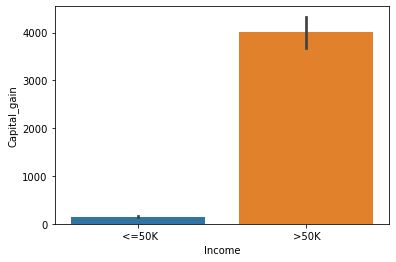

In [47]:
sns.barplot(x = 'Income', y = 'Capital_gain', data = df)

<AxesSubplot:xlabel='Income', ylabel='Education_num'>

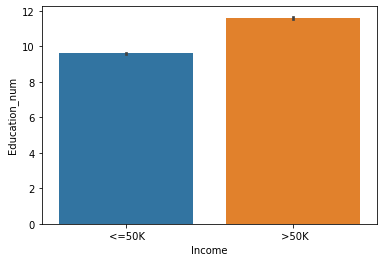

In [48]:
sns.barplot(x = 'Income', y = 'Education_num', data = df)


If the Education number is less than 10 then income is less than 50k, If Education num is more than 11 than income will be more than 50k.

<AxesSubplot:xlabel='Income', ylabel='Capital_loss'>

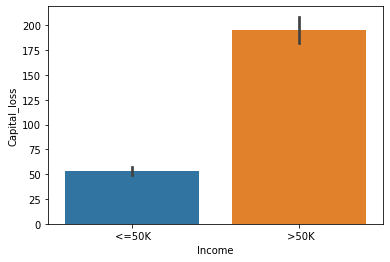

In [49]:
sns.barplot(x = 'Income', y = 'Capital_loss', data = df)

If Capital Loss is 50, income will be less than 50k and If Capital loss is more than 175, income will be more than 50k

<AxesSubplot:xlabel='Income', ylabel='Hours_per_week'>

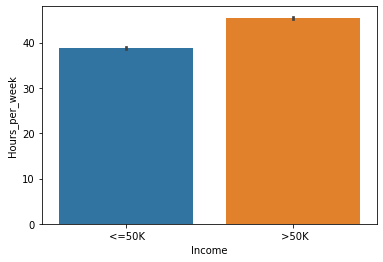

In [50]:
sns.barplot(x = 'Income', y = 'Hours_per_week', data = df)

If hours per week is less than 40 then Income will be less than 50k, If hours per week is more than 40 then Income will be more than 50k

In [51]:
df.describe()

,Age,Fnlwgt,Education_num,Capital_gain,Capital_loss,Hours_per_week
count,32560.000000,3.256000e+04,32560.000000,32560.000000,32560.000000,32560.000000
mean,38.581634,1.897818e+05,10.080590,1077.615172,87.306511,40.437469
std,13.640642,1.055498e+05,2.572709,7385.402999,402.966116,12.347618
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178315e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783630e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370545e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Capital_gain and Capital_loss have min values 0 and 25,50 and 75% values are Zeros.

There is much difference in values of different columns, so we'll do scaling.

In [52]:
label_list=list(df.select_dtypes(['object']).columns)  
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder() 
for i in label_list:
    df[i] = le.fit_transform(df[i])


In [53]:
df.head()


,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country,Income
0,50,5,83311,9,13,2,3,0,4,1,0,0,13,38,0
1,38,3,215646,11,9,0,5,1,4,1,0,0,40,38,0
2,53,3,234721,1,7,2,5,0,2,1,0,0,40,38,0
3,28,3,338409,9,13,2,9,5,2,0,0,0,40,4,0
4,37,3,284582,12,14,2,3,5,4,0,0,0,40,38,0


In [54]:
df = df.sample(frac=1, random_state = 0)

### Multi-Variate Analysis

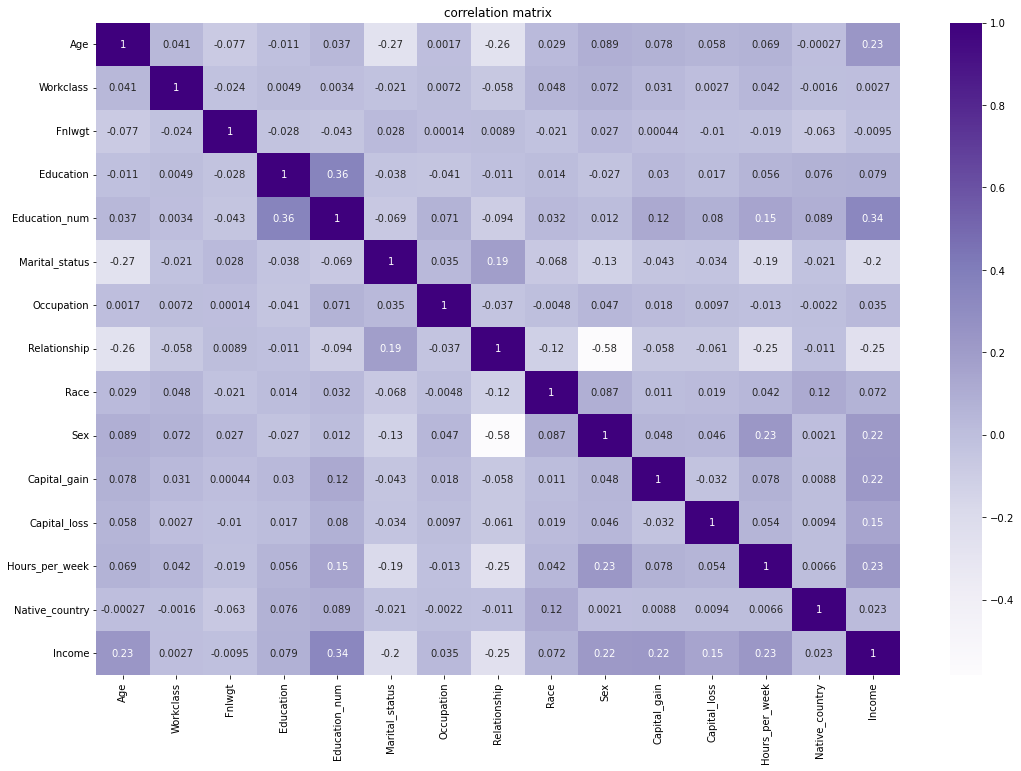

In [68]:
fig=plt.figure(figsize=(18,12))
hc=df.corr(method='pearson')
sns.heatmap(hc,annot=True,cmap="Purples")
plt.title("correlation matrix")
plt.show()

We can clearly see that there is not much correlation, even though Education_num have heighst corelation i.e. 34%

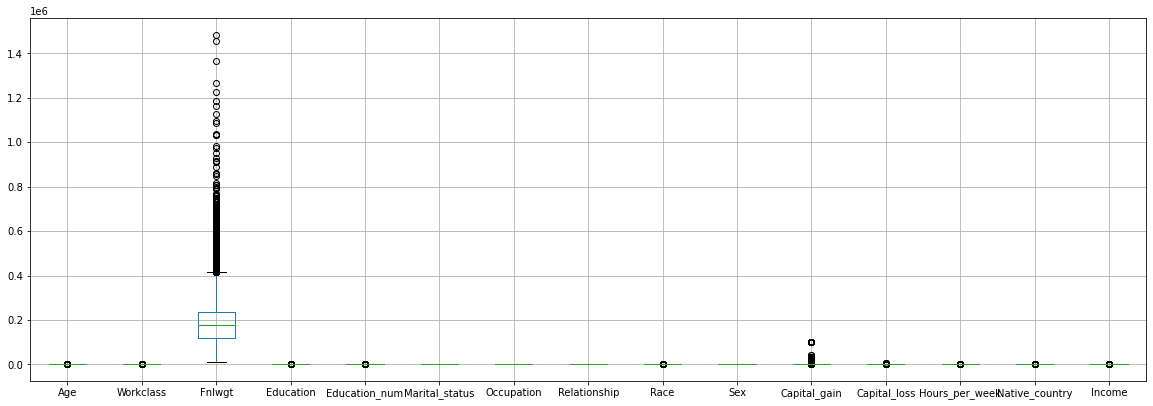

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
df.boxplot(figsize=[20,8])
plt.subplots_adjust(bottom=0.25)
plt.show()

In [70]:
import numpy as np
from scipy.stats import zscore
z=np.abs(zscore(df))
print(np.where(z>3))

(array([    2,     4,     9, ..., 32539, 32547, 32551], dtype=int64), array([13, 12,  0, ...,  8, 10,  8], dtype=int64))


In [71]:
df1=df[(z<3).all(axis = 1)]
print(df.shape)
print(df1.shape)

(32560, 15)
(27770, 15)


In [72]:
loss_percent=(32559-27769)/32559*100
print(loss_percent)

14.7117540465002


In [73]:
x = df.drop("Income", axis=1)
y = df["Income"]

In [74]:
x.skew()

Age                0.558738
Workclass          0.076178
Fnlwgt             1.446972
Education         -0.934063
Education_num     -0.311630
Marital_status    -0.013448
Occupation         0.000536
Relationship       0.786784
Race              -2.435332
Sex               -0.719244
Capital_gain      11.953690
Capital_loss       4.594549
Hours_per_week     0.227636
Native_country    -4.243083
dtype: float64

In [75]:
from sklearn.preprocessing import PowerTransformer
PT=PowerTransformer() 
for i in int_list:
    if abs(x.loc[:,i].skew())>0.55:
        x.loc[:,i]=PT.fit_transform(x.loc[:,i].values.reshape(-1,1))

### Scaling Data

In [76]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler() 
new = scale.fit(x)  
scale_x = new.transform(x) 

scaled_x = pd.DataFrame(scale_x, index=x.index, columns=x.columns)
x=scaled_x
x.head()

,Age,Workclass,Fnlwgt,Education,Education_num,Marital_status,Occupation,Relationship,Race,Sex,Capital_gain,Capital_loss,Hours_per_week,Native_country
22278,0.476686,0.571429,0.336528,1.000000,0.6,0.333333,0.307692,0.0,1.0,1.0,0.0,0.0,0.397959,0.95
8950,0.561811,0.428571,0.330628,1.000000,0.6,0.666667,0.230769,0.8,1.0,0.0,0.0,0.0,0.448980,0.95
7838,0.362885,0.428571,0.345955,0.333333,0.2,0.833333,0.692308,0.2,1.0,1.0,0.0,0.0,0.397959,0.30
16505,0.110668,0.428571,0.327069,1.000000,0.6,0.666667,0.000000,0.6,1.0,0.0,0.0,0.0,0.153061,0.95
19140,0.718571,0.428571,0.228073,0.333333,0.2,0.333333,0.538462,1.0,1.0,0.0,0.0,0.0,1.000000,0.95


In [77]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report,auc
import warnings
warnings.filterwarnings('ignore')
maxAccu=0
maxRS=0
for i in range(1,200):
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=i)
    LR = LogisticRegression()
    LR.fit(x_train,y_train)
    predrf = LR.predict(x_test)
    acc = accuracy_score(y_test, predrf)
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i
print("Best accuracy is",maxAccu," on Random_state ",maxRS)

Best accuracy is 0.8249385749385749  on Random_state  101


In [78]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.30,random_state=maxRS)

In [79]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [80]:
model=[LogisticRegression(),KNeighborsClassifier(),BernoulliNB(),SVC(),DecisionTreeClassifier(),RandomForestClassifier()]
for m in model:
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    print('accuracy score of ->', m)
    print(accuracy_score(y_test,pred))
    print(confusion_matrix(y_test,pred))
    print(classification_report(y_test,pred))
    score=cross_val_score(m,x,y,cv=5)
    print(score)
    print(score.mean())
    print("Difference between Accuracy score and cross validation score is - ",accuracy_score(y_test,pred)-score.mean())

accuracy score of -> LogisticRegression()
0.8249385749385749
[[6988  453]
 [1257 1070]]
              precision    recall  f1-score   support

           0       0.85      0.94      0.89      7441
           1       0.70      0.46      0.56      2327

    accuracy                           0.82      9768
   macro avg       0.78      0.70      0.72      9768
weighted avg       0.81      0.82      0.81      9768

[0.81388206 0.81695332 0.81787469 0.81541769 0.817414  ]
0.8163083538083538
Difference between Accuracy score and cross validation score is -  0.00863022113022116
accuracy score of -> KNeighborsClassifier()
0.828009828009828
[[6690  751]
 [ 929 1398]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      7441
           1       0.65      0.60      0.62      2327

    accuracy                           0.83      9768
   macro avg       0.76      0.75      0.76      9768
weighted avg       0.82      0.83      0.83      9768

[0.822

#### Random Forest Classifier have the heighst Accuracy and cross validation Score i.e. 85.97%

In [81]:
from sklearn.model_selection import RandomizedSearchCV

parameters = {"max_depth":[1,2,3,4,5,6,7,8,9,10,15,20],
              "max_features": [3,5,7,9],
              "min_samples_leaf":[2,3,4,5,6]}

clf = RandomizedSearchCV(RandomForestClassifier(), parameters)
clf.fit(x_train,y_train) #fitting train and test data
clf.best_params_  #Best parameters

{'min_samples_leaf': 5, 'max_features': 7, 'max_depth': 9}

In [82]:
clf_pred=clf.best_estimator_.predict(x_test)

In [83]:
accuracy_score(y_test,clf_pred)

0.8604627354627354

In [84]:
print(accuracy_score(y_test,clf_pred))
print(confusion_matrix(y_test,clf_pred))
print(classification_report(y_test,clf_pred))

0.8604627354627354
[[7088  353]
 [1010 1317]]
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7441
           1       0.79      0.57      0.66      2327

    accuracy                           0.86      9768
   macro avg       0.83      0.76      0.79      9768
weighted avg       0.85      0.86      0.85      9768



In [85]:
import joblib
joblib.dump(clf.best_estimator_,"Census.obj")
SVR_from_joblib=joblib.load("Census.obj")
Predicted = SVR_from_joblib.predict(x_test)
Predicted

array([1, 0, 1, ..., 0, 0, 1])